In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/Shareddrives/Capstone AIRBUS/Data/msn_37_fuel_leak_signals_preprocessed.csv', delimiter=';')

###**Conditional preprocessing**
####Depending on the dataset which is loaded, different preprocessing pipelines are applied. Overall, useless columns are dropped, together with the data referring to Pre-Flight, Engine Run and Post-Flight phases and remaining missing rows are dropped. For dataset 'msn02', a further missing values imputation is performed.
#### The derivatives of the numerical columns are computed and the values are scaled using RobustSclaler, to make them feasible for a PCA analysis and preserve the outliers' magnitude.


In [ ]:
if data.shape[1] == 111:
    # Apply a reduced preprocessing pipeline for the 'msn02' dataset
    pca_data1 = data.drop(data[(data["FLIGHT_PHASE_COUNT"] == 1) | (data["FLIGHT_PHASE_COUNT"] == 2) | (data["FLIGHT_PHASE_COUNT"] == 12)].index)
    pca_data1.drop(['UTC_TIME','MSN','Flight','day','month','time','year','FUEL_USED_1','FUEL_USED_2','FUEL_USED_3','FUEL_USED_4'], axis=1, inplace=True)
    column_means = pca_data1.mean()
    pca_data1 = pca_data1.fillna(column_means)
    pca_data1.dropna(inplace=True)
    print(f'Number of deleted rows: {len(data)-len(pca_data1)}, leaving a working dataset of {len(pca_data1)} rows.')
else:
    # Apply the preprocessing pipeline for other datasets
    pca_data1 = data.drop(data[(data["FLIGHT_PHASE_COUNT"] == 1) | (data["FLIGHT_PHASE_COUNT"] == 2) | (data["FLIGHT_PHASE_COUNT"] == 12)].index)
    pca_data1.drop(['UTC_TIME','MSN','Flight','FUEL_USED_1','FUEL_USED_2','FUEL_USED_3','FUEL_USED_4', 'FLIGHT_PHASE_COUNT'], axis=1, inplace=True)
    columns_to_scale = pca_data1.columns
    for column in columns_to_scale:
        pca_data1[column] = pca_data1[column].diff()
    pca_data1.dropna(inplace=True)
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(pca_data1[columns_to_scale])
    pca_data1[columns_to_scale] = scaled_data
    print(f'Number of deleted rows: {len(data)-len(pca_data1)}, leaving a working dataset of {len(pca_data1)} rows.')

Number of deleted rows: 392346, leaving a working dataset of 2844299 rows.


Number of flights in the dataset:

In [ ]:
data['Flight'].nunique()

498

### **PCA for anomaly detection**
####Traditional analysis of the number of components.

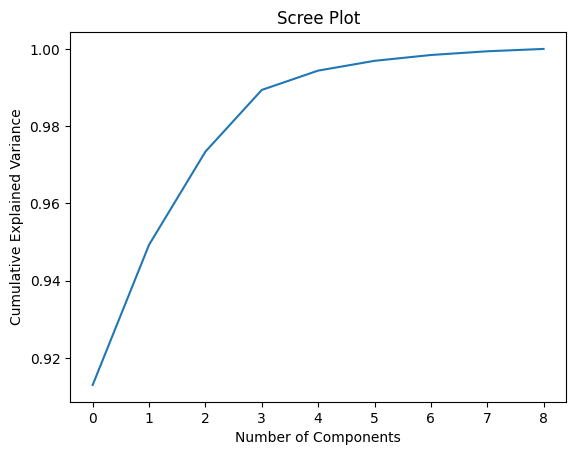

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca.fit(pca_data1)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scree plot
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Perform PCA with MLE
pca_mle = PCA(n_components='mle')      #Minka's MLE to choose the number of components
data1_pca_mle = pca_mle.fit_transform(pca_data1)
data1_reconstructed_mle = pca_mle.inverse_transform(data1_pca_mle)
reconstruction_error_mle = mean_squared_error(pca_data1, data1_reconstructed_mle)

# Perform PCA with a manually-selected number of components
n_components_manual = 3 # Select your desired number of components
pca_manual = PCA(n_components=n_components_manual)
data1_pca_manual = pca_manual.fit_transform(pca_data1)
data1_reconstructed_manual = pca_manual.inverse_transform(data1_pca_manual)
reconstruction_error_manual = mean_squared_error(pca_data1, data1_reconstructed_manual)

print("Reconstruction Error (MLE):", reconstruction_error_mle)
print("Reconstruction Error (Manual):", reconstruction_error_manual)

Reconstruction Error (MLE): 0.15452630900302516
Reconstruction Error (Manual): 6.724476778957276


#### Plotting the reconstruction error from 1 to n components, where n is the number of components suggested by the Minka's MLE approach.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#Getting the number of components from the Minka's MLE method defined above
n_components_mle = pca_mle.n_components_

# Initialize lists to store the number of components and the corresponding reconstruction errors
num_components_list = []
reconstruction_error_list = []

for n in range(1, n_components_mle + 1):
    # Perform PCA with 'n' components
    pca = PCA(n_components=n)
    data1_pca = pca.fit_transform(pca_data1)
    data1_reconstructed = pca.inverse_transform(data1_pca)

    # Calculate reconstruction error
    reconstruction_error = mean_squared_error(pca_data1, data1_reconstructed)

    # Append the number of components and reconstruction error to the lists
    num_components_list.append(n)
    reconstruction_error_list.append(reconstruction_error)

In [ ]:
import plotly.express as px

# Create a dataframe with the data
df = pd.DataFrame({'Number of Components': num_components_list, 'Reconstruction Error': reconstruction_error_list})

# Create an interactive scatter plot using Plotly
fig = px.scatter(df, x='Number of Components', y='Reconstruction Error', hover_data=['Reconstruction Error'])
fig.update_traces(mode='lines+markers')
fig.update_layout(
    title='Reconstruction Error vs Number of Components',
    xaxis_title='Number of Components',
    yaxis_title='Reconstruction Error'
)
fig.show()

#### Apply PCA with the desired method ('mle' for automatic number of components or setting it manually based on the scree plot.

In [ ]:
# Perform PCA with MLE
pca_mle = PCA(n_components='mle')      #Minka's MLE to choose the number of components
data1_pca = pca_mle.fit_transform(pca_data1)

#### Reconstruct the data from the reduced dimensions

In [ ]:
data1_reconstructed = pca.inverse_transform(data1_pca)

#### Compute the reconstruction error as the mean squared error between the original data and the reconstructed data

In [ ]:
reconstruction_error = ((pca_data1 - data1_reconstructed) ** 2).mean(axis=1)

#### Identify samples with high reconstruction errors as potential anomalies

In [ ]:
threshold = reconstruction_error_mle.mean() + (0.5 * reconstruction_error.std())  # Adjust the threshold
anomaly_indices = reconstruction_error[reconstruction_error > threshold].index

In [ ]:
print("Potential anomaly indices:", anomaly_indices)

Potential anomaly indices: Int64Index([    663,    6801,    6810,    6811,    6814,    6816,    6850,
               6851,    6854,    6908,
            ...
            3233692, 3233775, 3233779, 3233782, 3233785, 3233805, 3233858,
            3233859, 3235026, 3235447],
           dtype='int64', length=12413)


#### Identifying as leaks only anomalies constitued by more than n consecutive anomaly indices (n=40 in our case).

In [ ]:
sequences = []
current_sequence = []
seql = []

# Iterate over the numbers list
for i in range(len(anomaly_indices)-1):
    # Check if the next number is consecutive
    if anomaly_indices[i+1] == anomaly_indices[i] + 1:
        # If it is, add the current number to the current sequence
        current_sequence.append(anomaly_indices[i])
    else:
        # If it's not, add the current number and the current sequence to the sequences list
        current_sequence.append(anomaly_indices[i])
        sequences.append(current_sequence)
        # Reset the current sequence
        current_sequence = []

# Add the last number to the last sequence
current_sequence.append(anomaly_indices[-1])
sequences.append(current_sequence)

# Append sequences that are over 10 seconds long
for seq in sequences:
  if len(seq) > 40:
    seql.append(seq)
    print(seq)

[429722, 429723, 429724, 429725, 429726, 429727, 429728, 429729, 429730, 429731, 429732, 429733, 429734, 429735, 429736, 429737, 429738, 429739, 429740, 429741, 429742, 429743, 429744, 429745, 429746, 429747, 429748, 429749, 429750, 429751, 429752, 429753, 429754, 429755, 429756, 429757, 429758, 429759, 429760, 429761, 429762, 429763]
[1898867, 1898868, 1898869, 1898870, 1898871, 1898872, 1898873, 1898874, 1898875, 1898876, 1898877, 1898878, 1898879, 1898880, 1898881, 1898882, 1898883, 1898884, 1898885, 1898886, 1898887, 1898888, 1898889, 1898890, 1898891, 1898892, 1898893, 1898894, 1898895, 1898896, 1898897, 1898898, 1898899, 1898900, 1898901, 1898902, 1898903, 1898904, 1898905, 1898906, 1898907, 1898908, 1898909, 1898910, 1898911, 1898912, 1898913, 1898914, 1898915, 1898916, 1898917, 1898918, 1898919, 1898920, 1898921, 1898922, 1898923, 1898924, 1898925, 1898926]
[2012141, 2012142, 2012143, 2012144, 2012145, 2012146, 2012147, 2012148, 2012149, 2012150, 2012151, 2012152, 2012153, 2012

---------------------------

#### Create a parallel dataset out of anomalies identified as leaks

In [ ]:
# Flatten the 'anomaly_indices' list
anomaly_indices_flat = [index for sublist in seql for index in sublist]

# Create the dataframe 'anomaly_data' using flattened 'anomaly_indices'
anomaly_data = data.iloc[anomaly_indices_flat]

#### Check the number of minutes of anomaly

In [ ]:
anomaly_data.shape[0]//60

6

#### Computing the columns contributing more to the reconstruction error

The column-wise standard deviation is calculated for both datasets and the columns where the standard deviation in the 'anomaly_data' is higher than in the non-anomaly data are identified.

In [ ]:
# Calculate the column-wise standard deviation for both datasets
non_anomaly_std = data.drop(anomaly_indices).std()
anomaly_std = anomaly_data.std()

# Compare the standard deviations and identify columns with higher variation in 'anomaly_data'
columns_with_higher_variation = anomaly_std[anomaly_std > non_anomaly_std]

# Print the columns with higher variation in 'anomaly_data'
print("Columns with higher variation in 'anomaly_data':")
print(columns_with_higher_variation)

Columns with higher variation in 'anomaly_data':
VALUE_FOB            7675.830453
VALUE_FUEL_QTY_CT    2982.279447
dtype: float64


<ipython-input-22-974378dac033>:2: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-22-974378dac033>:3: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



#### Exploring the values of specific columns

Here you can find a list of the columns useful for the following lines

In [ ]:
anomaly_data.columns.tolist()

['UTC_TIME',
 'FUEL_USED_2',
 'FUEL_USED_3',
 'FUEL_USED_4',
 'FW_GEO_ALTITUDE',
 'VALUE_FOB',
 'VALUE_FUEL_QTY_CT',
 'VALUE_FUEL_QTY_FT1',
 'VALUE_FUEL_QTY_FT2',
 'VALUE_FUEL_QTY_FT3',
 'VALUE_FUEL_QTY_FT4',
 'VALUE_FUEL_QTY_LXT',
 'VALUE_FUEL_QTY_RXT',
 'FLIGHT_PHASE_COUNT',
 'FUEL_USED_1',
 'Flight',
 'MSN']

You can insert here the name of a **categorical** column:

In [ ]:
categorical_column = 'FLIGHT_PHASE_COUNT'

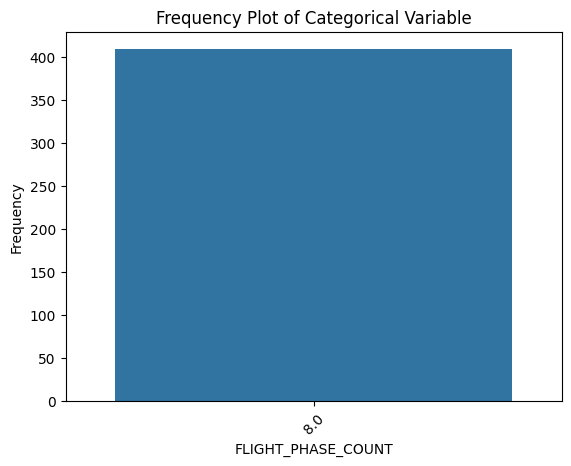

In [ ]:
column_values = anomaly_data[categorical_column]

# Create a countplot using seaborn
sns.countplot(x=column_values)

# Set labels and title
plt.xlabel(categorical_column)
plt.ylabel("Frequency")
plt.title("Frequency Plot of Categorical Variable")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

And here the comparison with the original data:

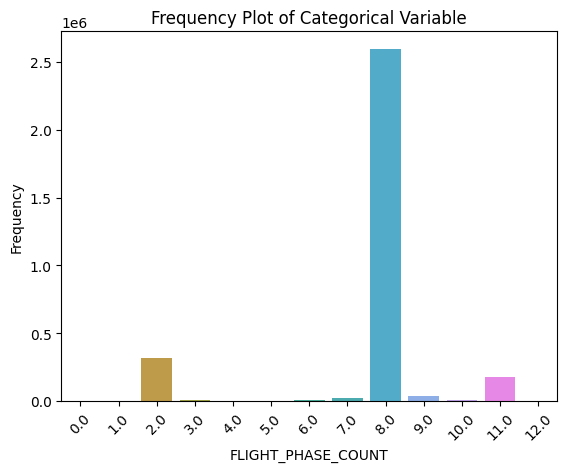

In [ ]:
column_values = data[categorical_column]

# Create a countplot using seaborn
sns.countplot(x=column_values)

# Set labels and title
plt.xlabel(categorical_column)
plt.ylabel("Frequency")
plt.title("Frequency Plot of Categorical Variable")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

----------------------------

You can insert here the name of a **numerical** column:

In [ ]:
numerical_column = 'VALUE_FUEL_QTY_RXT'

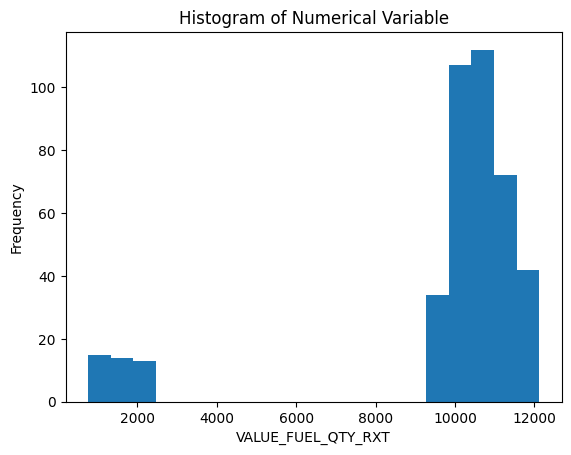

In [ ]:
column_values = anomaly_data[numerical_column]

# Create a histogram using matplotlib
plt.hist(column_values, bins=20)  # Adjust the number of bins as needed

# Set labels and title
plt.xlabel(numerical_column)
plt.ylabel("Frequency")
plt.title("Histogram of Numerical Variable")

# Display the plot
plt.show()

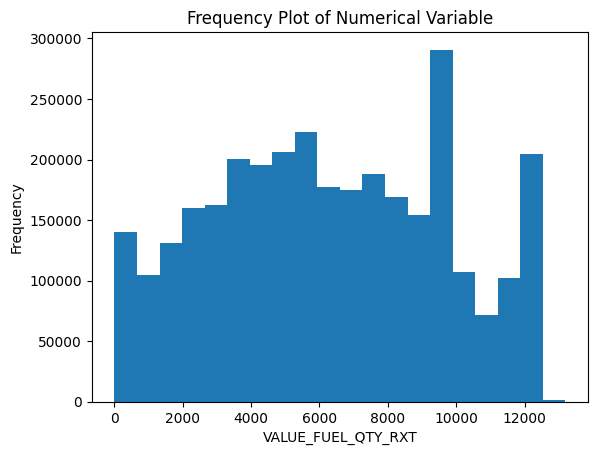

In [ ]:
column_values = data[numerical_column]

# Create a histogram using matplotlib
plt.hist(column_values, bins=20)  # Adjust the number of bins as needed

# Set labels and title
plt.xlabel(numerical_column)
plt.ylabel("Frequency")
plt.title("Frequency Plot of Numerical Variable")

# Display the plot
plt.show()

#### Computing the difference in average between original data and anomaly data

In [ ]:
avg_value_anomaly = anomaly_data[numerical_column].mean()
avg_value_original = data[numerical_column].mean()
percentage_diff = ((avg_value_original - avg_value_anomaly) / avg_value_anomaly) * 100

print(f"The difference in the column's average value between the anomaly data and the full dataset is: {percentage_diff}%")

The difference in the column's average value between the anomaly data and the full dataset is: -35.295022651937266%


In [ ]:
numerical_columns = [
 'VALUE_FOB',
 'VALUE_FUEL_QTY_CT',
 'VALUE_FUEL_QTY_FT1',
 'VALUE_FUEL_QTY_FT2',
 'VALUE_FUEL_QTY_FT3',
 'VALUE_FUEL_QTY_FT4',
 'VALUE_FUEL_QTY_LXT',
 'VALUE_FUEL_QTY_RXT',]

percentage_diff_df = pd.DataFrame(columns=['Column', '% change in Anomaly vs. Full data'])

for column in numerical_columns:
    avg_value_anomaly = anomaly_data[column].mean()
    avg_value_original = data[column].mean()
    percentage_diff = ((avg_value_original - avg_value_anomaly) / avg_value_anomaly) * 100

    percentage_diff_df = percentage_diff_df.append({'Column': column, '% change in Anomaly vs. Full data': percentage_diff}, ignore_index=True)

percentage_diff_df

<ipython-input-31-8509d4cba8e7>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-8509d4cba8e7>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-8509d4cba8e7>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-8509d4cba8e7>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-8509d4cba8e7>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-8509d4cba8e7>:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

,Column,% change in Anomaly vs. Full data
0,VALUE_FOB,-35.713132
1,VALUE_FUEL_QTY_CT,-88.180100
2,VALUE_FUEL_QTY_FT1,-7.449520
3,VALUE_FUEL_QTY_FT2,-6.789932
4,VALUE_FUEL_QTY_FT3,-7.225367
5,VALUE_FUEL_QTY_FT4,-6.629188
6,VALUE_FUEL_QTY_LXT,-42.972168
7,VALUE_FUEL_QTY_RXT,-35.295023
